### CZ Income

August 14, 2019

Brian Dew, @bd_econ


----

Basic idea is that some places have low income but also low prices while some places have high income but housing is extremely expensive. The ACS household records have data on household income, rent, and selected owner's expenses. I calculate housing-adjusted income per household member for each commuting zone, and select a cutoff point to measure what share of each local area is below the national income distribution cutoff. 

----


To do:

- Print sample size max and min
- Speed up merge
- Add some citations and explanatory text
- Add text to map


In [1]:
# Import libraries and adjust settings
%matplotlib inline
import pandas as pd
import os
os.environ['PROJ_LIB'] = '/home/brian/miniconda3/share/proj'
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings("ignore", category=mpl.cbook.mplDeprecation)
os.chdir('/home/brian/Documents/ACS/data/')

plt.rc('font', family='Lato')
plt.rcParams['text.color'] = 'dimgray'

In [2]:
# Read and pre-process ACS microdata
cols = ['ST', 'PUMA', 'WGTP', 'ADJINC', 'HINCP', 
        'NP', 'ADJHSG', 'GRNTP', 'SMOCP']
dtypes = {'ST': str, 'PUMA': str}
inc_adj = lambda x: (x['ADJINC'] / 1000000) * x['HINCP']
hsg_adj = lambda x: ((x['ADJHSG'] / 1000000) * x['GRNTP'].fillna(0) + 
                     (x['ADJHSG'] / 1000000) * x['SMOCP'].fillna(0)) * 12
puma = lambda x: x['ST'] + x['PUMA']
pp_inc = lambda x: (x['INC_ADJ'] - x['HSG_ADJ']) / x['NP']
files = ['psam_husa.csv', 'psam_husb.csv']

df = pd.concat(
    [(pd.read_csv(file, usecols=cols, dtype=dtypes)
        .query('NP > 0')
        .assign(PUMA = puma, 
                INC_ADJ = inc_adj, 
                HSG_ADJ = hsg_adj, 
                PP_INC = pp_inc))
        [['PUMA', 'WGTP', 'PP_INC']]
    for file in files]).astype({'PUMA': int})

df.head(3)

In [5]:
# Calculate threshold for map
percentile = 1/3
df.sort_values('PP_INC', inplace=True)
cumsum = df.WGTP.cumsum()
cutoff = df.WGTP.sum() * percentile
cutpoint = df.PP_INC[cumsum >= cutoff].iloc[0]

print(f'Percentile {percentile * 100:.0f}: ${cutpoint:,.2f}')

In [8]:
# Match PUMAs to commuter zones
cz_match = pd.read_stata('cw_puma2010_czone.dta')
cz_dict = {cz: [(puma, afactor) 
                for puma, z, afactor 
                in cz_match[cz_match['czone'] == cz].values] 
           for cz in cz_match['czone'].unique()}

d = {}
for cz, puma_list in cz_dict.items():
    pop = 0
    below_cut = 0    
    for puma, afactor in puma_list:  
        data = (df[df['PUMA'] == puma]
                  .assign(WGT = lambda x: x['WGTP'] * afactor))
        pop += data.WGTP.sum()
        below_cut += data.loc[data['PP_INC'] < cutpoint, 'WGTP'].sum()
        
    sh_below = below_cut / pop
    d[cz] = [sh_below, pop]
    
result = pd.DataFrame(d)
result.index = ['share', 'weight']
result = result.T

In [10]:
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.PiYG
norm = mpl.colors.Normalize(vmin=result['share'].min(), vmax=result['share'].max())

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

legend = result.sort_values('share')

legend['length'] = legend['weight'] / legend['weight'].sum()
legend['start'] = legend['length'].cumsum()
legend = legend.drop(['weight'], axis=1)
lgd = legend.to_dict()

max_val = f'{legend["share"].max() * 100:.1f}%'
min_val = f'{legend["share"].min() * 100:.1f}%'

<Figure size 432x288 with 0 Axes>

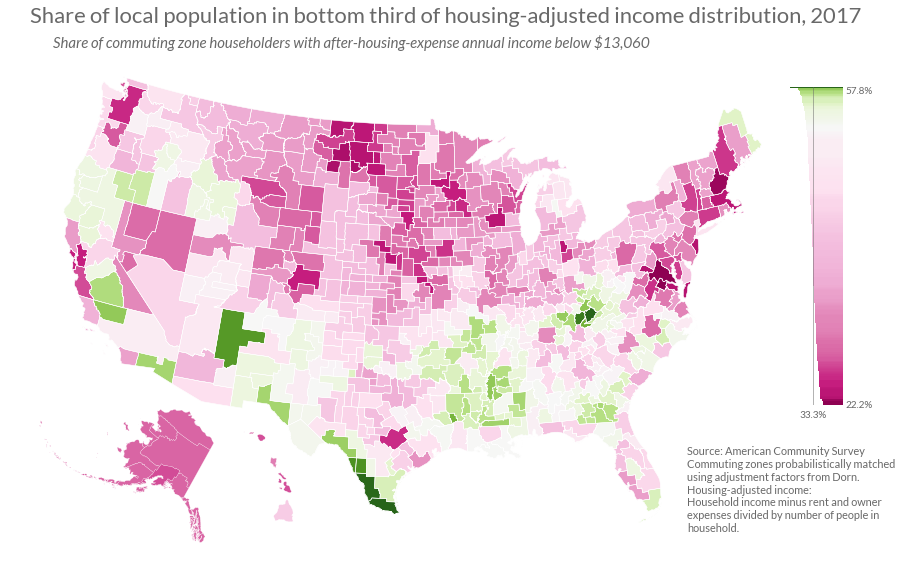

In [26]:
# Draw map
plt.gcf()
plt.figure(figsize=(18,9))

m.readshapefile('../shapefiles/cz1990', 'cz', drawbounds=True, color='white')

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.35 + 1100000, 
                  y * 0.35 - 1300000) for x, y in shape]
    ax.add_patch(Polygon(shape, facecolor=cmap(norm(d[info['cz']][0])), 
                         edgecolor='white', linewidth=0.2))
title = 'Share of local population in bottom third of housing-adjusted income distribution, 2017'
subtitle = f'Share of commuting zone householders with after-housing-expense annual income below ${int(round(cutpoint, -1)):,}'
note = 'Source: American Community Survey\nCommuting zones probabilistically matched\nusing adjustment factors from Dorn.\nHousing-adjusted income:\nHousehold income minus rent and owner\nexpenses divided by number of people in\nhousehold.'
ax.text(0.03, 1.09, title, fontsize=22, transform=ax.transAxes)
ax.text(0.06, 1.04, subtitle, fontsize=15, transform=ax.transAxes, style='italic')
ax.text(0.89, 0.05, note, fontsize=11, transform=ax.transAxes)
ax.axis('off')    

ax_inset = inset_axes(ax, width='-12%', height='65%', loc=1, borderpad=2)
for cz in cz_dict.keys():
    rect = Rectangle(xy=(lgd['share'][cz], lgd['start'][cz]), 
                     width=-lgd['share'][cz], height=-lgd['length'][cz], 
                     fc=cmap(norm(lgd['share'][cz])), ec=None)
    ax_inset.add_patch(rect)
ax_inset.axvline(x=1/3, color='dimgray', zorder=1, lw=0.5)
ax_inset.text(1/3, -0.04, '33.3%', ha='center')
ax_inset.text(-0.02, 0.98, max_val)
ax_inset.text(-0.02, -0.01, min_val)
ax_inset.axis('off')
plt.savefig('../acs_map.jpg', bbox_inches='tight', dpi=500)
plt.show();